# Application Model

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import shap
import ast
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [2]:
from mobpy import *
from select_feature import *

In [3]:
data = pd.read_csv('cs-training.csv')

In [4]:
data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
data.shape

(150000, 12)

In [6]:
data.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [7]:
drop = ['Unnamed: 0','SeriousDlqin2yrs']

In [8]:
X = data.drop(drop, axis=1)
Y = data['SeriousDlqin2yrs']

In [9]:
#MEAN DR
np.mean(Y)

0.06684

In [10]:
data.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


# 1. Linear regression

## Monotone Optimal Binning

In [21]:
%%time
woe_iv_all, bad_columns = create_woe_iv(X, Y, min_bins=2, max_bins=5)

2023-09-02 19:08:20,444 — Mobpy — DEBUG — e1: 
2023-09-02 19:08:21,112 — Mobpy — DEBUG — e1: 


Wall time: 954 ms


In [22]:
# n is Number of cores
# woe_iv_all, bad_columns = create_woe_iv_optimal(X, Y, n=2)

In [34]:
woe_iv_all.head()

,VAR_NAME,BUCKET,MIN_VALUE,MAX_VALUE,SHARE,COUNT,EVENT,NON_EVENT,EVENT_RATE,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,RevolvingUtilizationOfUnsecuredLines,"(-1000000000.0, 0.0832]",0.000000,0.019222,0.4000,60000,1079.0,58921.0,0.017983,0.982017,0.107620,0.420942,1.363888,1.057914
1,RevolvingUtilizationOfUnsecuredLines,"(0.0832, 0.271]",0.083182,0.271481,0.2000,30000,877.0,29123.0,0.029233,0.970767,0.087473,0.208060,0.866502,1.057914
2,RevolvingUtilizationOfUnsecuredLines,"(0.271, 0.699]",0.271510,0.698855,0.2000,30000,2107.0,27893.0,0.070233,0.929767,0.210154,0.199273,-0.053164,1.057914
3,RevolvingUtilizationOfUnsecuredLines,"(0.699, 1000000000.0]",0.698866,50708.000000,0.2000,30000,5963.0,24037.0,0.198767,0.801233,0.594754,0.171725,-1.242254,1.057914
4,age,"(-1000000000.0, 36.0]",0.000000,29.000000,0.1591,23865,2628.0,21237.0,0.110119,0.889881,0.262118,0.151721,-0.546753,0.252552


In [35]:
# Filter feature(iv>0.5)
IV = pd.DataFrame({'IV':woe_iv_all.groupby('VAR_NAME').IV.max()})
IV_GOOD = IV[
    (IV['IV']>0.05)
#              &
#              (IV['IV']<0.95)
].sort_values('IV', ascending=False)

In [36]:
IV_GOOD.reset_index()

,VAR_NAME,IV
0,RevolvingUtilizationOfUnsecuredLines,1.057914
1,NumberOfTime30-59DaysPastDueNotWorse,0.665194
2,NumberOfTime60-89DaysPastDueNotWorse,0.572373
3,age,0.252552
4,MonthlyIncome,0.070257


In [37]:
GOOD_IV_FEATURE = list(IV_GOOD.index)

In [38]:
GOOD_IV_FEATURE

['RevolvingUtilizationOfUnsecuredLines',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'age',
 'MonthlyIncome']

In [39]:
df_plot = woe_iv_all[woe_iv_all['VAR_NAME']=='age']

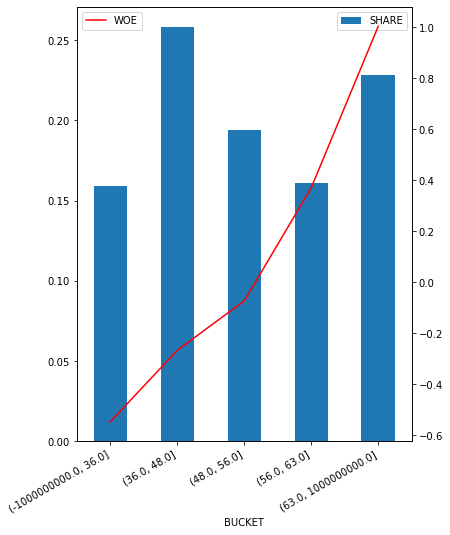

In [40]:
fig, ax1 = plt.subplots(figsize=(6,8))
ax2 = ax1.twinx()
df_plot.plot.bar(x='BUCKET', y='SHARE', rot=0, ax=ax1)
df_plot.plot(x='BUCKET', y='WOE', color = 'r', ax=ax2)
plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

## Feature Selection

## Shap

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X[GOOD_IV_FEATURE], Y, test_size=0.25, random_state=12345)

In [42]:
model = CatBoostClassifier(iterations = 500
                          , verbose=100
                          , depth = 6
                          , thread_count =20
                          , eval_metric = 'AUC'                   
                          )

In [43]:
model.fit(X_train, y_train)

Learning rate set to 0.146157
0:	total: 169ms	remaining: 1m 24s
100:	total: 1.47s	remaining: 5.8s
200:	total: 2.82s	remaining: 4.2s
300:	total: 4.17s	remaining: 2.76s
400:	total: 5.53s	remaining: 1.37s
499:	total: 6.87s	remaining: 0us


In [44]:
shap_test = shap.TreeExplainer(model).shap_values(X_test)

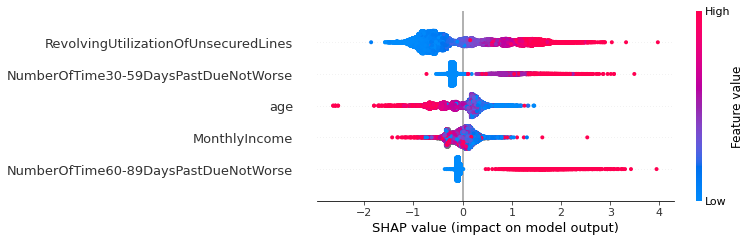

In [45]:
shap.summary_plot(shap_test, X_test, max_display=25, show=False)

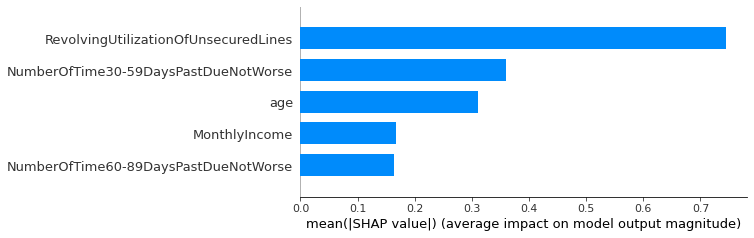

In [46]:
plt.savefig('plot.png', bbox_inches='tight')
shap.summary_plot(shap_test, X_test, plot_type = 'bar')

In [47]:
shap_sum = np.abs(shap_test).mean(axis=0)
importance_df = pd.DataFrame([X_test.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
0,RevolvingUtilizationOfUnsecuredLines,0.743979
1,NumberOfTime30-59DaysPastDueNotWorse,0.359323
3,age,0.311172
4,MonthlyIncome,0.167776
2,NumberOfTime60-89DaysPastDueNotWorse,0.164156


In [48]:
shap_good_var = importance_df['column_name'][:4]

In [49]:
shap_good_var

0    RevolvingUtilizationOfUnsecuredLines
1    NumberOfTime30-59DaysPastDueNotWorse
3                                     age
4                           MonthlyIncome
Name: column_name, dtype: object

## MAUC_SELECT

In [50]:
def mauc_select(data, Y, first_var):
    filter_col = data.columns
    drop_var = []
    mauc_final = pd.DataFrame()
    best_var = []
    best_var.append(first_var)
    
    n = data[filter_col].shape[1]
    X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.25, random_state=12345)
    for i in range(n-1):
        mauc = pd.DataFrame()
        ctb_est = CatBoostClassifier(iterations=100
                            , learning_rate=0.05
                            , verbose=False
                            , depth=8
                            , thread_count=2)
        ctb_est.fit(X_train[best_var], y_train)
        
        y_prob = ctb_est.predict_proba(X_test[best_var])[:, 1]
        gini_best = 100*(2*roc_auc_score(y_test, y_prob) - 1)
        for col in filter_col:
            if col in drop_var or col in best_var:
                continue
            draft_var = best_var.copy()
            draft_var.append(col)
            ctb_est.fit(X_train[draft_var], y_train)
            y_prob_draft = ctb_est.predict_proba(X_test[draft_var])[:, 1]
            gini_draft = 100*(2*roc_auc_score(y_test, y_prob_draft) - 1)
            
            mgini = gini_draft - gini_best
            if mgini < -0.5:
                drop_var.append(col)
            mauc_ = pd.DataFrame({'VAR_NAME': col, 'mauc': [mgini], 'gini': gini_draft})
            mauc = mauc.append(mauc_, ignore_index=True)
        if mauc.empty:
            break
        mauc = mauc.reset_index(drop=True)
        max_mauc = mauc['mauc'].idxmax()
        print(mauc)
        if mauc['mauc'].max() > 0.1:
            best_var.append(mauc['VAR_NAME'].iloc[max_mauc])
            mauc_final = mauc_final.append(mauc.iloc[max_mauc])
        else:
            break
        if len(best_var) > 25:
            break
    return best_var, mauc_final  

In [51]:
best_var, mauc_final = mauc_select(X[shap_good_var], Y, 'RevolvingUtilizationOfUnsecuredLines')

                               VAR_NAME      mauc       gini
0  NumberOfTime30-59DaysPastDueNotWorse  8.081826  63.419098
1                                   age  1.296401  56.633673
2                         MonthlyIncome  0.836325  56.173597
        VAR_NAME      mauc       gini
0            age  0.989338  64.408436
1  MonthlyIncome  0.449989  63.869086
        VAR_NAME    mauc       gini
0  MonthlyIncome  0.3551  64.763536


In [52]:
mauc_final

,VAR_NAME,gini,mauc
0,NumberOfTime30-59DaysPastDueNotWorse,63.419098,8.081826
0,age,64.408436,0.989338
0,MonthlyIncome,64.763536,0.355100


In [53]:
best_var

['RevolvingUtilizationOfUnsecuredLines',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'age',
 'MonthlyIncome']

## SHAP_SELECT

In [54]:
def mauc_shap(df, y):
    draft_var = df.columns.tolist()
    mauc_final = pd.DataFrame()
    n = len(draft_var)
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25, random_state=12345)
    for i in range(n-1):
        mauc = pd.DataFrame()
        ctb_est = CatBoostClassifier(iterations = 100
                            , learning_rate = 0.05
                            , verbose = False
                            , depth=8
                            , thread_count = 2)
        ctb_est.fit(X_train[draft_var], y_train)
        y_prob_draft = ctb_est.predict_proba(X_test[draft_var])[:, 1]
        gini_draft = 100*(2*roc_auc_score(y_test, y_prob_draft) - 1)
        
        n_vars = len(draft_var)
        var_name = str(draft_var)
        
        shap_test = shap.TreeExplainer(ctb_est).shap_values(X_test[draft_var])
        shap_sum = np.abs(shap_test).mean(axis=0)
        importance_df = pd.DataFrame([X_test[draft_var].columns.tolist(), shap_sum.tolist()]).T
        importance_df.columns = ['VARS', 'shap_importance']
        importance_df = importance_df.sort_values('shap_importance', ascending=False)
        
        mauc = pd.DataFrame({'N_VARS': [n_vars], 'gini': [gini_draft], 'VAR_NAME': [var_name]})
        mauc_final = mauc_final.append(mauc, ignore_index=True)
        draft_var.remove(importance_df['VARS'].tail(1).tolist()[0])
    return mauc_final

In [55]:
mauc_shap_select = mauc_shap(X, Y)

In [56]:
mauc_shap_select

,N_VARS,gini,VAR_NAME
0,10,71.815480,"['RevolvingUtilizationOfUnsecuredLines', 'age'..."
1,9,71.440056,"['RevolvingUtilizationOfUnsecuredLines', 'age'..."
2,8,71.484048,"['RevolvingUtilizationOfUnsecuredLines', 'age'..."
3,7,71.109562,"['RevolvingUtilizationOfUnsecuredLines', 'age'..."
4,6,70.709430,"['RevolvingUtilizationOfUnsecuredLines', 'age'..."
5,5,68.956374,"['RevolvingUtilizationOfUnsecuredLines', 'age'..."
6,4,68.072725,"['RevolvingUtilizationOfUnsecuredLines', 'age'..."
7,3,64.345815,"['RevolvingUtilizationOfUnsecuredLines', 'age'..."
8,2,63.419098,"['RevolvingUtilizationOfUnsecuredLines', 'Numb..."


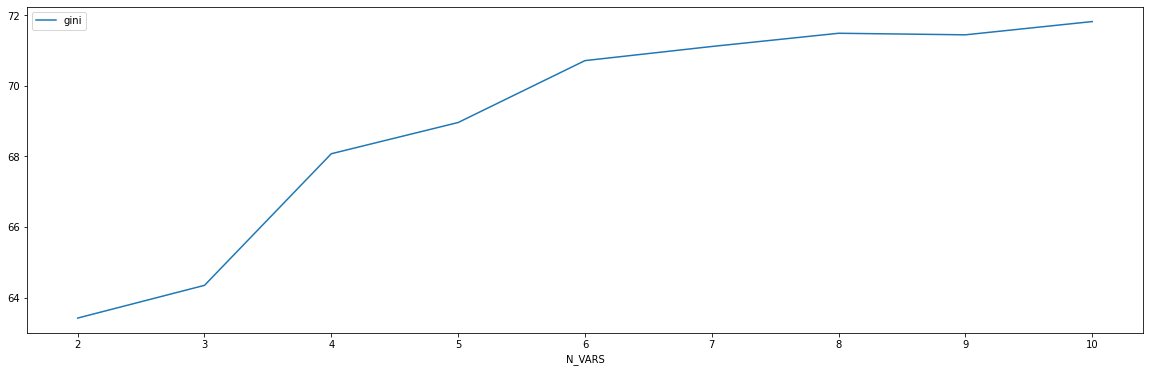

In [57]:
mauc_shap_select.plot(x='N_VARS', y='gini', figsize=(20,6))
plt.savefig('gini_by_nvars.png')
plt.show()

In [58]:
good_shap = mauc_shap_select.iloc[3]

In [59]:
good_shap = ast.literal_eval(good_shap['VAR_NAME'])

In [60]:
good_shap

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse']

## ONLY GOOD VAR

### LOGREG

### 1.Train_TEST

In [61]:
GOOD_VAR_IV =['RevolvingUtilizationOfUnsecuredLines',
                'NumberOfTime30-59DaysPastDueNotWorse',
                'NumberOfTime60-89DaysPastDueNotWorse',
                'age']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X[GOOD_VAR_IV], Y, test_size=0.25, random_state=15)

In [64]:
woe_iv_all, bad_columns = create_woe_iv(X_train, y_train, min_bin_size = 0.02)

2023-09-02 19:11:04,419 — Mobpy — DEBUG — e1: 


In [65]:
woe_iv_all.head()

,VAR_NAME,BUCKET,MIN_VALUE,MAX_VALUE,SHARE,COUNT,EVENT,NON_EVENT,EVENT_RATE,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,RevolvingUtilizationOfUnsecuredLines,"(-1000000000.0, 0.0829]",0.000000,0.019250,0.400000,45000,832,44168,0.018489,0.981511,0.111364,0.420531,1.328716,1.029217
1,RevolvingUtilizationOfUnsecuredLines,"(0.0829, 0.272]",0.082953,0.271624,0.200000,22500,660,21840,0.029333,0.970667,0.088342,0.207943,0.856051,1.029217
2,RevolvingUtilizationOfUnsecuredLines,"(0.272, 0.701]",0.271638,0.701376,0.200000,22500,1567,20933,0.069644,0.930356,0.209744,0.199307,-0.051044,1.029217
3,RevolvingUtilizationOfUnsecuredLines,"(0.701, 1000000000.0]",0.701468,50708.000000,0.200000,22500,4412,18088,0.196089,0.803911,0.590550,0.172219,-1.232287,1.029217
4,NumberOfTime30-59DaysPastDueNotWorse,"(-1000000000.0, 0.5]",0.000000,0.000000,0.840418,94547,3743,90804,0.039589,0.960411,0.501004,0.864561,0.545608,0.764834


In [66]:
X_train_woe = replace_feature_by_woe_optimal(X_train, woe_iv_all)
X_test_woe = replace_feature_by_woe_optimal(X_test, woe_iv_all)

In [67]:
X_train_woe = replace_feature_by_woe_optimal(X_train, woe_iv_all)
X_test_woe = replace_feature_by_woe_optimal(X_test, woe_iv_all)

In [68]:
X_train_woe.head()

,WOE_RevolvingUtilizationOfUnsecuredLines,WOE_NumberOfTime30-59DaysPastDueNotWorse,WOE_NumberOfTime60-89DaysPastDueNotWorse,WOE_age
76686,1.328716,0.545608,0.293725,-0.204376
149125,0.856051,0.545608,0.293725,0.984227
97182,0.856051,0.545608,0.293725,-0.204376
56561,-1.232287,0.545608,0.293725,-0.204376
34418,-0.051044,0.545608,0.293725,-0.460076


### 2.FIT

In [69]:
lr = LogisticRegression(random_state=5, C=10**6)
lr.fit(X_train_woe, y_train)

LogisticRegression(C=1000000, random_state=5)

In [70]:
coefficients = pd.concat([pd.DataFrame(X_train_woe.columns), pd.DataFrame(np.transpose(lr.coef_))], axis=1)
coefficients.columns = ['VAR_NAME', 'coef']

intercept = pd.DataFrame({'VAR_NAME':['intercept'], 'coef':lr.intercept_})
coefficients = pd.concat([intercept, coefficients])
coefficients['score'] = np.floor(-coefficients['coef']*50/np.log(2))
coefficients['score'] = np.where(coefficients['VAR_NAME'] == 'intercept', coefficients['score'] + 500, coefficients['score'])
coefficients['VAR_NAME'] = coefficients[['VAR_NAME']].applymap(lambda x: str(x).lstrip('WOE_'))
# coefficients['WOE'] = coefficients[['VAR_NAME']].applymap(lambda x: str(x).lstrip('_')[-1])
# coefficients['WOE'] = coefficients[['WOE']].applymap(lambda x: x[:8])

In [71]:
coefficients

,VAR_NAME,coef,score
0,intercept,-2.627268,689.0
0,RevolvingUtilizationOfUnsecuredLines,-0.733266,52.0
1,NumberOfTime30-59DaysPastDueNotWorse,-0.610400,44.0
2,NumberOfTime60-89DaysPastDueNotWorse,-0.552750,39.0
3,age,-0.489859,35.0


In [72]:
woe_iv_all['WOE'] = woe_iv_all[['WOE']].applymap(lambda x: str(x)[:8])

In [73]:
woe_iv_all.head()

,VAR_NAME,BUCKET,MIN_VALUE,MAX_VALUE,SHARE,COUNT,EVENT,NON_EVENT,EVENT_RATE,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,RevolvingUtilizationOfUnsecuredLines,"(-1000000000.0, 0.0829]",0.000000,0.019250,0.400000,45000,832,44168,0.018489,0.981511,0.111364,0.420531,1.328715,1.029217
1,RevolvingUtilizationOfUnsecuredLines,"(0.0829, 0.272]",0.082953,0.271624,0.200000,22500,660,21840,0.029333,0.970667,0.088342,0.207943,0.856050,1.029217
2,RevolvingUtilizationOfUnsecuredLines,"(0.272, 0.701]",0.271638,0.701376,0.200000,22500,1567,20933,0.069644,0.930356,0.209744,0.199307,-0.05104,1.029217
3,RevolvingUtilizationOfUnsecuredLines,"(0.701, 1000000000.0]",0.701468,50708.000000,0.200000,22500,4412,18088,0.196089,0.803911,0.590550,0.172219,-1.23228,1.029217
4,NumberOfTime30-59DaysPastDueNotWorse,"(-1000000000.0, 0.5]",0.000000,0.000000,0.840418,94547,3743,90804,0.039589,0.960411,0.501004,0.864561,0.545608,0.764834


In [74]:
scorecard = pd.merge(woe_iv_all[['VAR_NAME', 'MIN_VALUE', 'MAX_VALUE', 'WOE']],
                    coefficients[['VAR_NAME','coef', 'score']], on='VAR_NAME', how = 'left')
scorecard = pd.concat([scorecard, coefficients[coefficients['VAR_NAME']=='intercept']])
scorecard.head()

,VAR_NAME,MIN_VALUE,MAX_VALUE,WOE,coef,score
0,RevolvingUtilizationOfUnsecuredLines,0.000000,0.019250,1.328715,-0.733266,52.0
1,RevolvingUtilizationOfUnsecuredLines,0.082953,0.271624,0.856050,-0.733266,52.0
2,RevolvingUtilizationOfUnsecuredLines,0.271638,0.701376,-0.05104,-0.733266,52.0
3,RevolvingUtilizationOfUnsecuredLines,0.701468,50708.000000,-1.23228,-0.733266,52.0
4,NumberOfTime30-59DaysPastDueNotWorse,0.000000,0.000000,0.545608,-0.610400,44.0


In [75]:
# scorecard = pd.merge(woe_iv_all[['VAR_NAME', 'MIN_VALUE', 'MAX_VALUE', 'WOE']],
#                     coefficients[['coef', 'score', 'WOE']], on='WOE', how = 'left')
# scorecard['score'] = np.where(np.isnan(scorecard['score']), 0, scorecard['score'])
# scorecard = pd.concat([scorecard, coefficients[coefficients['VAR_NAME']=='intercept']])
# scorecard

### 3.Evaluate

### 3.1 Gini

In [76]:
y_prob_train = lr.predict_proba(X_train_woe)
roc_auc = roc_auc_score(y_train, y_prob_train[:,1])
gini_train = 2 * roc_auc - 1

In [77]:
y_prob_test = lr.predict_proba(X_test_woe)
roc_auc = roc_auc_score(y_test, y_prob_test[:,1])
gini_test = 2 * roc_auc - 1

In [78]:
gini_train_test = pd.DataFrame({'TRAIN': [gini_train], 'TEST': [gini_test]})
gini_train_test

,TRAIN,TEST
0,0.667366,0.677735


### 3.2 VIF

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [80]:
def vif(df):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['Feature'] = df.columns
    return vif

In [81]:
vif_factor = vif(X_train_woe)
vif_factor

,VIF_Factor,Feature
0,1.299730,WOE_RevolvingUtilizationOfUnsecuredLines
1,1.278357,WOE_NumberOfTime30-59DaysPastDueNotWorse
2,1.218839,WOE_NumberOfTime60-89DaysPastDueNotWorse
3,1.120123,WOE_age


# Save Model Report

In [84]:
writer = pd.ExcelWriter('model_report.xlsx', engine='xlsxwriter')

IV_GOOD.to_excel(writer, sheet_name='IV')

coefficients.to_excel(writer, sheet_name='COEF', index=False)

scorecard.to_excel(writer, sheet_name='SCORECARD', index=False)

gini_train_test.to_excel(writer, sheet_name='GINI', index=False)

vif_factor.to_excel(writer, sheet_name='VIF', index=False)

# gini_month.to_excel(writer, sheet_name='GINI_MONTH')

# PD_DR_BY_VARS_BUCKET.to_excel(writer, sheet_name='PD_DR_BY_VARS_BUCKET')

# psi_by_vars.to_excel(writer, sheet_name='PSI')

writer.save()

### CATBOOST